**Goal: Predict how likely a caseses sentencing is be very different if the convicted person was of a different race.**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import pearsonr
import dython

import pickle
import datetime as dt
import sys
import inspect
import json

sys.path.append('../scripts')
from predict_route import clean_data




Data Source: https://datacatalog.cookcountyil.gov/Courts/Sentencing/tg8v-tm6u/data  
Data Dictionary: https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf  
Data description: https://www.cookcountystatesattorney.org/resources/how-read-data

In [3]:
csv = '../data/Sentencing-cook_county.csv'
#csv = 'https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/rows.csv'
cols = ['CHARGE_COUNT',
        'CHARGE_DISPOSITION', 'UPDATED_OFFENSE_CATEGORY', 'PRIMARY_CHARGE_FLAG',
        'DISPOSITION_CHARGED_OFFENSE_TITLE', 'DISPOSITION_CHARGED_CLASS', 'SENTENCE_JUDGE',
        'SENTENCE_PHASE', 'COMMITMENT_TERM', 'COMMITMENT_UNIT', 'LENGTH_OF_CASE_in_Days',
        'AGE_AT_INCIDENT', 'RACE', 'GENDER', 'INCIDENT_CITY', 'LAW_ENFORCEMENT_AGENCY',
        'LAW_ENFORCEMENT_UNIT', 'SENTENCE_TYPE']
# 'CASE_PARTICIPANT_ID' and 'ARREST_DATE' could be useful if matched with another 
# dataset for including criminal history information
orig_data = pd.read_csv(csv, usecols=cols)
data = orig_data.copy()

/Users/noah.chasek-macfoy@ibm.com/Desktop/projects/embrace-sprint/data science dev git repo/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Explore distribution of categories in high cardinality variables

In [4]:
def check_cat_dist(data, col_name, thresh=.1, top_n=25):
    '''fraction of data in levels that represent less than 10% of total'''
    freqs = data[col_name].value_counts()
    frac_by_freq = freqs.groupby(freqs).sum()/data.shape[0] # percent of data represented by categories with x members
    thresh = data.shape[0]*thresh
    mask = frac_by_freq.index < thresh
    frac_below_thresh = frac_by_freq[mask].sum() # percent of data in categories that each represent less than 10% of all obs
    num_above_thresh = (~mask).sum() # number of categories which have more than thresh % (e.g. 10%) of data in them
    frac_top_n = freqs[:top_n].sum()/data.shape[0]
    return frac_below_thresh, num_above_thresh, frac_top_n

In [5]:
# look at distribution of obs across categories
thresh = .05
top_n=73
for i in data.select_dtypes('object').columns:
    print(i)
    a,b,c = check_cat_dist(data, i, thresh, top_n)
    print(f'{data[i].unique().shape[0]} categories')
    print(f'{round(a*100,3)}% of categories have less than {thresh*100}% of the data in them')
    print(f'{b} categories have more than {thresh*100}% of the data in them')
    print(f'{round(c*100,3)}% of the data is in the most frequent {top_n} categories', '\n')


# future: turn into transformer with thresh and top_n as params (is that already in OneHotEncoder?)

DISPOSITION_CHARGED_OFFENSE_TITLE
1645 categories
72.739% of categories have less than 5.0% of the data in them
3 categories have more than 5.0% of the data in them
89.105% of the data is in the most frequent 73 categories 

DISPOSITION_CHARGED_CLASS
14 categories
1.563% of categories have less than 5.0% of the data in them
6 categories have more than 5.0% of the data in them
99.992% of the data is in the most frequent 73 categories 

CHARGE_DISPOSITION
28 categories
2.622% of categories have less than 5.0% of the data in them
2 categories have more than 5.0% of the data in them
100.0% of the data is in the most frequent 73 categories 

SENTENCE_JUDGE
329 categories
99.693% of categories have less than 5.0% of the data in them
0 categories have more than 5.0% of the data in them
87.804% of the data is in the most frequent 73 categories 

SENTENCE_PHASE
6 categories
4.386% of categories have less than 5.0% of the data in them
1 categories have more than 5.0% of the data in them
100.0% o

In [6]:
data['DISPOSITION_CHARGED_OFFENSE_TITLE'].value_counts()

POSSESSION OF A CONTROLLED SUBSTANCE                                                                              37083
AGGRAVATED DRIVING UNDER THE INFLUENCE OF ALCOHOL                                                                 15246
RETAIL THEFT                                                                                                      13549
FELONY DRIVING WHILE DRIVER?S LICENSE, PERMIT, OR PRIVILEGE TO OPERATE A MOTOR VEHICLE IS SUSPENDED OR REVOKED    10758
AGGRAVATED UNLAWFUL USE OF WEAPON                                                                                 10035
                                                                                                                  ...  
ATT FLS REPT TO PUBLIC SAFETY AGCY                                                                                    1
AGG INTIMIDATION/CVLN REPT FEL                                                                                        1
AGG FLEEING/BODILY INJURY/2ND           

In [7]:
data['DISPOSITION_CHARGED_CLASS'].value_counts()

4    98345
2    49500
3    37091
1    23399
A    16088
X    13440
M     2665
B      610
C      394
Z       67
O       21
P       17
U        3
Name: DISPOSITION_CHARGED_CLASS, dtype: int64

#### Clean Data

In [8]:
# This function remove null values, standardizes spellings of categories, and 
data = clean_data(orig_data)

#### JSON Schema of cleaned data

In [9]:
# JSON of first example
json_str = orig_data.iloc[0].to_json()
print(json.dumps(json.loads(json_str), indent=2))

{
  "PRIMARY_CHARGE_FLAG": true,
  "DISPOSITION_CHARGED_OFFENSE_TITLE": "ARMED ROBBERY",
  "CHARGE_COUNT": 1,
  "DISPOSITION_CHARGED_CLASS": "X",
  "CHARGE_DISPOSITION": "Plea Of Guilty",
  "SENTENCE_JUDGE": "James L Rhodes",
  "SENTENCE_PHASE": "Original Sentencing",
  "SENTENCE_TYPE": "Prison",
  "COMMITMENT_TERM": 10.0,
  "COMMITMENT_UNIT": "Year(s)",
  "LENGTH_OF_CASE_in_Days": 1307.0,
  "AGE_AT_INCIDENT": 17.0,
  "RACE": "Black",
  "GENDER": "Male",
  "INCIDENT_CITY": null,
  "LAW_ENFORCEMENT_AGENCY": "PROMIS Data Conversion",
  "LAW_ENFORCEMENT_UNIT": null,
  "UPDATED_OFFENSE_CATEGORY": "PROMIS Conversion"
}


In [10]:
# get data types for each variable
orig_data_dtypes = ['str' if str(i) is 'object' else str(i) for i in orig_data[cols].dtypes]
dict(zip(cols, orig_data_dtypes))

{'CHARGE_COUNT': 'int64',
 'CHARGE_DISPOSITION': 'str',
 'UPDATED_OFFENSE_CATEGORY': 'str',
 'PRIMARY_CHARGE_FLAG': 'bool',
 'DISPOSITION_CHARGED_OFFENSE_TITLE': 'str',
 'DISPOSITION_CHARGED_CLASS': 'str',
 'SENTENCE_JUDGE': 'str',
 'SENTENCE_PHASE': 'str',
 'COMMITMENT_TERM': 'str',
 'COMMITMENT_UNIT': 'str',
 'LENGTH_OF_CASE_in_Days': 'float64',
 'AGE_AT_INCIDENT': 'float64',
 'RACE': 'str',
 'GENDER': 'str',
 'INCIDENT_CITY': 'str',
 'LAW_ENFORCEMENT_AGENCY': 'str',
 'LAW_ENFORCEMENT_UNIT': 'str',
 'SENTENCE_TYPE': 'str'}

### Build Sentence Length Model

#### Split Data

In [11]:
# train test split
target = 'COMMITMENT_TERM'
x_data = data.drop(target,axis=1)
y_data = data[target]

rng = np.random.RandomState()
rs = rng.get_state()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=rng)

In [12]:
rng.set_state(rs)
data_train, data_test = train_test_split(data, random_state=rng)

#### Build Prediction Pipeline

In [27]:
# Train a new model or use existing saved model
TRAIN = False # True #

Define categorical feature encoding step

In [13]:
ohe = OneHotEncoder(handle_unknown='ignore')
categorical_feats = ('cats', ohe, x_data.select_dtypes('object').columns)
feat_trans = ColumnTransformer([categorical_feats], remainder='passthrough')

Define model type

In [14]:
model = XGBRegressor()

In [15]:
feat_transform = ('ct', feat_trans)
sentence_model = ('xgb', model)
sentence_pipe = Pipeline([feat_transform, sentence_model])

In [16]:
from skopt import BayesSearchCV
from skopt.callbacks import DeltaYStopper
from skopt.space import Real, Categorical, Integer

Define model hyperparameter search space.

In [17]:
# fit HPO
# define hyperparameter search space
search_space = {} 
search_space['xgb__n_estimators'] = Integer(40, 600)
search_space['xgb__max_depth'] = Integer(3, 10)
search_space['xgb__min_child_weight'] = Integer(1,12) 
search_space['xgb__gamma'] = (0., 500.) # thinking about scale of MSE
search_space['xgb__subsample'] = (.5, 1)
search_space['xgb__colsample_bytree'] = (.5, 1)
search_space['xgb__reg_lambda'] = (1e-6, 1e6, "log-uniform")
search_space['xgb__reg_alpha'] = (1e-5, 1e1, "log-uniform")
search_space['xgb__learning_rate'] = (.05, .3)
search_space

{'xgb__n_estimators': Integer(low=40, high=600, prior='uniform', transform='identity'),
 'xgb__max_depth': Integer(low=3, high=10, prior='uniform', transform='identity'),
 'xgb__min_child_weight': Integer(low=1, high=12, prior='uniform', transform='identity'),
 'xgb__gamma': (0.0, 500.0),
 'xgb__subsample': (0.5, 1),
 'xgb__colsample_bytree': (0.5, 1),
 'xgb__reg_lambda': (1e-06, 1000000.0, 'log-uniform'),
 'xgb__reg_alpha': (1e-05, 10.0, 'log-uniform'),
 'xgb__learning_rate': (0.05, 0.3)}

In [19]:
# fit model / search for optimal HPs for optimal model config
#earlystop = DeltaYStopper(delta=.5,n_best=7)
if TRAIN:
    hpo = BayesSearchCV(sentence_pipe,
                        search_space,
                        cv=4,
                        scoring = 'neg_mean_squared_error', 
                        iid=False,
                        n_jobs = -1,
                        n_iter = 100,
                        verbose = 2,
                        n_points=6
                        ) 
    %time hpo.fit(x_train, y_train)#, callback=earlystop) # 31 mins

In [20]:
if not TRAIN:
    HPO_PATH = '../saved_models/bayesHPO_mae1.53.pkl'
    with open(HPO_PATH, 'rb') as f:
        hpo = pickle.load(f)

In [21]:
# Access prediction pipeline with optimal hyperparameters
sentence_pipe = hpo.best_estimator_ 
val_score = hpo.best_score_
display(hpo.best_params_)
preds = sentence_pipe.predict(x_test)
test_score = hpo.scorer_._score_func(y_test, preds)
print('MSE:',test_score)

OrderedDict([('model__colsample_bytree', 0.5),
             ('model__gamma', 0.0),
             ('model__learning_rate', 0.21157112549163443),
             ('model__max_depth', 9),
             ('model__min_child_weight', 1),
             ('model__n_estimators', 525),
             ('model__reg_alpha', 5.214696563276624),
             ('model__reg_lambda', 0.4288604351585181),
             ('model__subsample', 1.0)])

MSE: 4.552088787836333


#### Evaluate Accuracy and Serialize Model

In [22]:
# evaluate accuracy
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)
print('Mean Absolute Error:',mae)
print('Fraction of total target variance accounted for (r^2):', r2)

Mean Absolute Error: 1.1443824110025802
Fraction of total target variance accounted for (r^2): 0.9377888276407689


In [23]:
# pickle sentence length pipeline obj
if TRAIN:
    PIPE = sentence_pipe
    ts = dt.datetime.now().strftime('%Y-%m-%d_%Hh%Mm%Ss')
    name_pipe = f'../saved_models/sentence_pipe_mae{round(mae,3)}_{ts}'
    with open(name_pipe+'.pkl', 'wb') as f:
        pickle.dump(PIPE, f, -1)

In [24]:
# pickle HPO obj
if TRAIN:
    HPO = hpo
    #ts = dt.datetime.now().strftime('%Y-%m-%d_%Hh%Mm%Ss')
    #name=name_pipe.replace('sentence_pipe', 'bayesHPO')
    name = f'../saved_models/bayesHPO_mae{round(mae,3)}'
    with open(name+'.pkl', 'wb') as f:
        pickle.dump(HPO, f, -1)

In [25]:
res = hpo.optimizer_results_[0]

Check which hyperparameters are most correlated with generalizable model performance

Text(0.5, 1.0, 'Correlations of Hyperparameters to Model Performace')

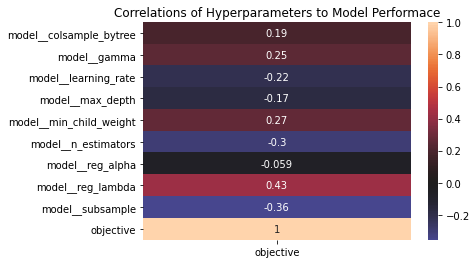

In [31]:
df = pd.DataFrame(res['x_iters'],columns=[i for i in hpo.best_params_])
df = df.assign(objective=res['func_vals'])
sns.heatmap(df.corr().loc[: ,['objective']],annot=True, center=0)
plt.title('Correlations of Hyperparameters to Model Performace')

#### Evaluate Error Distribution and Plots

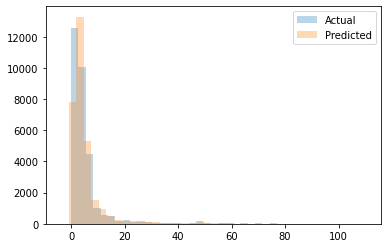

In [32]:
# distribution of target and predictions in test set 
plt.hist(y_test, bins=40, alpha=.3, label='Actual')
plt.hist(preds, bins=40, alpha=.3, label='Predicted')
plt.legend()
plt.show()

In [33]:
error = y_test - preds

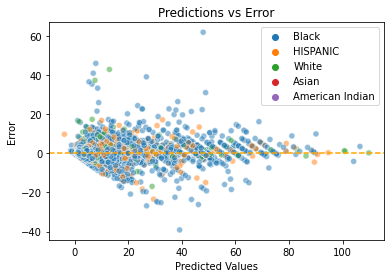

In [34]:
factor = 'RACE' # 'DISPOSITION_CHARGED_CLASS' #  
sns.scatterplot(preds, error, alpha=.5, hue=x_test[factor].values)
plt.axhline(0, ls='--', c='orange')
plt.title('Predictions vs Error')
plt.xlabel('Predicted Values')
plt.ylabel('Error')
plt.show()

In [35]:
print('Race Distribution in Test Data')
x_test.groupby('RACE').size()/x_test.shape[0]

Race Distribution in Test Data


RACE
American Indian    0.000421
Asian              0.003753
Black              0.742647
HISPANIC           0.146957
White              0.106222
dtype: float64

(60.0, -60.0)

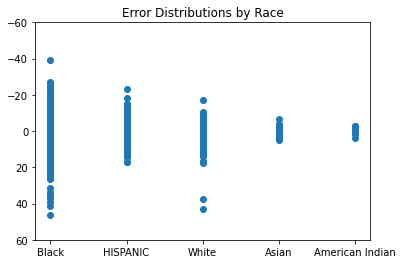

In [46]:
plt.scatter(x_test['RACE'], error)
plt.title('Error Distributions by Race')
plt.ylim([60,-60])
# there are are some BIG outliers (90 years off the correct prediction....)

Errors for Black people are larger, however they are the largest share of 
the sample.  Are the larger errors for black people a natural result of their over representation in the data or does it mean I am missing distinguishing features among black people.

### Build Racial discrepancy evaluator
Using the theoretical approach of https://github.com/IBM/causallib/blob/master/examples/standardization.ipynb

In [37]:
from predict_route import make_counterfactual
print(inspect.getsource(make_counterfactual))

def make_counterfactual(data):
    '''Take data and switch race variable to "opposite" value'''
    # white --> black
    # non-white --> white
    race_counterfactual_map =\
    {'Black': 'White',
    'White': 'Black',
    'HISPANIC': 'White',
    'Asian': 'White',
    'American Indian': 'White'}

    data_counterfactual = data.copy()
    data_counterfactual['RACE'] = data['RACE'].map(race_counterfactual_map)
    return data_counterfactual



In [38]:
# display discrepancy calculation code
from predict_route import estimate_discrepancy
print(inspect.getsource(estimate_discrepancy))

def estimate_discrepancy(model, data, return_pred=False):
    '''
    Estimate discrepancy in sentence length if race were switched.
    
    The discrepancy estimate represents # of additional years to which the
    actual profile would be sentenced over the counterfactual profile. A 
    positive discrepancy means that the actual race would recieve a 
    harsher sentence than the counterfactual race.

    Params:
        return_pred: (bool) if True, returns a tuple of 
            (descrepancy, prediction), otherwise just returns descrepancy

    Returns:
        discrepancy is a 1-d numpy array
    '''
    pred = model.predict(data)
    diff = pred - model.predict(make_counterfactual(data))
    if return_pred:
        return diff, pred

    return diff



In [39]:
rng.set_state(rs) # reset random state for replicable split
x_train, x_test = train_test_split(x_data, random_state=rng)

In [40]:
import json

In [41]:
discrepancy = estimate_discrepancy(sentence_pipe, x_test)
discrepancy_s = pd.Series(discrepancy)

In [42]:
# calculate as percent of (estimated?) sentence
percent_discrepancy = (discrepancy/y_test) * 100
#percent_discrepancy = (discrepancy/preds) * 100

In [43]:
# drop cases where sentence lenght is 0 for now
mask = (y_test == 0)
discrepancy = discrepancy[~mask.values]
percent_discrepancy = percent_discrepancy[~mask.values]

In [44]:
# save list of test discrepancies, to evaluate percentile discrepancy in runtime data
if TRAIN:
    # include some indicator of how/where the train/test split was made?
    with open('../saved_models/test_data_percentage_discrepancies.json', 'w') as f:
        json.dump(percent_discrepancy.tolist(), f)

### Explore Racial discrepancies in Sentencing

In [50]:
# SOME HUGE outliers in percent discrepancy
percent_discrepancy_s = pd.Series(percent_discrepancy)
percent_discrepancy_s.groupby(x_test['RACE']).describe()

# This appears to be a case where the 50th% percentile (i.e. median) is more 
# informative than the mean (bc of the outliers)
# We can say that, most of the time,
# black people are treated btw 2% less harshly and 16% more harshly than white people and 
# white people are treated btw 14% less harshly and 4% more harshly than black people

,count,mean,std,min,25%,50%,75%,max
RACE,,,,,,,,
American Indian,13.0,6.633590,15.851970,-19.385672,3.950226,10.178089,17.024374,30.108941
Asian,116.0,-10.146813,51.729998,-441.873169,-15.360083,-0.645307,8.753917,39.087963
Black,22874.0,3.888210,205.084568,-26725.855738,-2.050090,6.059327,16.773002,3928.585812
HISPANIC,4538.0,-2.116823,27.023548,-573.592806,-8.805819,0.067082,8.119220,267.066884
White,3280.0,-10.879325,232.244984,-13233.369440,-14.134422,-3.964025,4.500099,193.672037


[Text(0.5, 1.0, 'Average Percent Racial Sentencing Discrepancy by Race')]

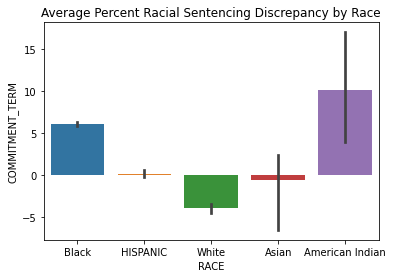

In [51]:
# distribution of positive discrepancies
percent_discrepancy_by_race = percent_discrepancy_s.groupby(x_test['RACE']).mean()
ax = sns.barplot(x=x_test['RACE'], y=percent_discrepancy_s, estimator=np.median)
ax.set(title='Average Percent Racial Sentencing Discrepancy by Race')

# result: interesting that hispanic appears to be sentenced less harshly than white

Text(0.5, 1.0, 'Distribution of Racial Discrepancies by Race')

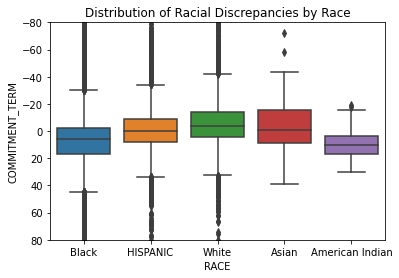

In [52]:
sns.boxplot(x=x_test['RACE'], y=percent_discrepancy_s)
plt.ylim([80, -80])
plt.title('Distribution of Racial Discrepancies by Race')

#### Feature Importance with respect to Sentence Length

In [54]:
import re

In [55]:
# per level on categoricals

# subclass the ColumnTransformer instead?
def get_feature_names(ohe_name, column_transformer, delim='_*_'):
    '''
    Get feature names that include factor names, from a ColumnTransformer 
    containing a onehot encoder. Builtin get_feature_names() 
    method  (ver 0.23) only includes factor column index. 

    Params:
        ohe_name: (str) name of OneHotEncoder obj in .transformers_ of ColumnTransformer
    '''
    cols = column_transformer.get_feature_names()
    
    
    
    # col index for onehot encoder named 'cats'
    cats_cols = {i[0]:i[2] for i in column_transformer.transformers_}['cats']
    # replace x0, x1, etx with original col names
    cats_idx = [re.findall(ohe_name + r'__x(\d)_', label) for label in cols]
    fixed_cols = [re.sub(ohe_name + r'__(x\d)_', cats_cols[int(cat_i[0])]+delim, cols[i]) if cat_i else cols[i] for i, cat_i in enumerate(cats_idx)] 
    # Alt:
    #cats_level_cols = column_transformer.named_transformers_[ohe_name].get_feature_names(input_features=cats_cols)
    #cats_idx = [i for i, c in enumerate(cols) if c.startswith(ohe_name + r'__')]
    #fixed_cols=cols.copy()
    #for i, cats_i in enumerate(cats_idx):
    #    fixed_cols[cats_i] = cats_level_cols[i]

    return fixed_cols


col_names = get_feature_names('cats', sentence_pipe['ct'])

In [56]:
## Get normalized feature imp dict and series

bst = sentence_pipe['model'].get_booster() # name changed to 'xgb' in retrain
# remove brackets in col names bc they break xgb feature importance code
col_names_clean =  [re.sub(r'[\[\]]', '\~', i) for i in col_names]
default_feat_names = bst.feature_names.copy()

importance_type = 'gain' # 'weight' # 'total_gain' #  
bst.feature_names = col_names_clean 
feat_imps_d = bst.get_score(importance_type=importance_type)
# reset feature names bc defaults to validate_features=True in sklearn xgb api for .predict() 
# but doesn't allow for feature names for newdate to be set during predit() 
bst.feature_names=default_feat_names
# add in zero importance features
feat_imps_d = {n:feat_imps_d.get(n, 0) for n in col_names_clean}
# make feat imps sum to 1000
total = sum(feat_imps_d.values())
feat_imps_d_norm = {k:round((v/total)*1000,3) for k,v in feat_imps_d.items()} 
feat_imps_s = pd.Series(feat_imps_d_norm).sort_values()[::-1]

Text(0.5, 1.0, 'Feature importance at the Category Level (top 20)')

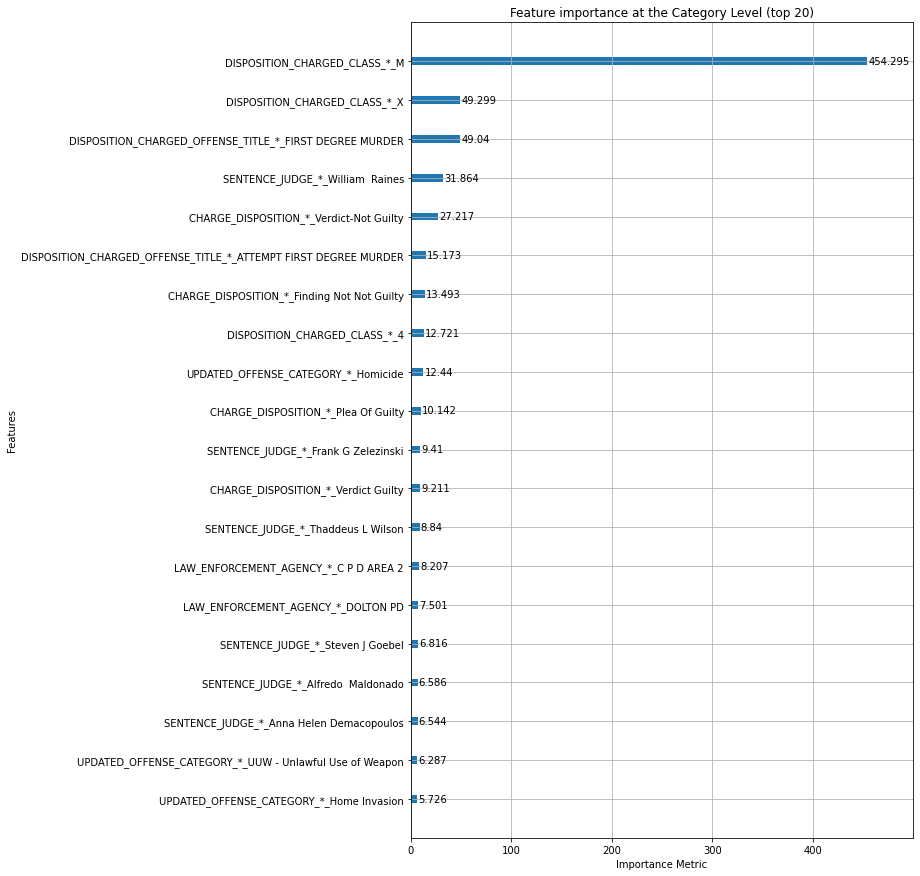

In [57]:
# highly informative:
# * Primary charge flag is highly influential... should I remove non-primary charges... 
# because the sentence won't be "primarilly" driven by that? # EXPLORE check that primary flag 
# is associated with longer sentences?
# * being black is a discriminative feature, so are serveral serious crimes, as well as how you got to be convicted.
# * gain vs wt or total gain brings in MALE and several judges names... but drops race...
# * 'gain' also shows that age at incident and charge count are only there because they are high cardinality

# * Class M (first degree murder) and the highest felony class are predictive, interestingly the lowest class of 
# felony is also predictive, maybe because it is a discontinuity in sentencing from the most severe misdemeanor.
#* and it will be interesting to see the distributions of the judges and police departments


# do EDA on distributions of target on Nolle prosecution, and mental health

# charge count is almost certainly inflated because it is a contiuous variable

# do EDA on the shape of the relationship between target and influential vars
 
xgb.plot_importance(feat_imps_d_norm, max_num_features=20,
                xlabel='Importance Metric',
                   )
plt.gcf().set_size_inches(9,15)
plt.title('Feature importance at the Category Level (top 20)')

In [58]:
from sklearn.inspection import permutation_importance

In [59]:
%%time
res=permutation_importance(sentence_pipe, x_test, y_test, scoring='neg_mean_squared_error', n_jobs=-1)

CPU times: user 3.36 s, sys: 656 ms, total: 4.02 s
Wall time: 40.5 s


CPU times: user 38.8 ms, sys: 4.06 ms, total: 42.8 ms
Wall time: 41.2 ms


Text(0.5, 1.0, 'Feature Importance at the Variable Level')

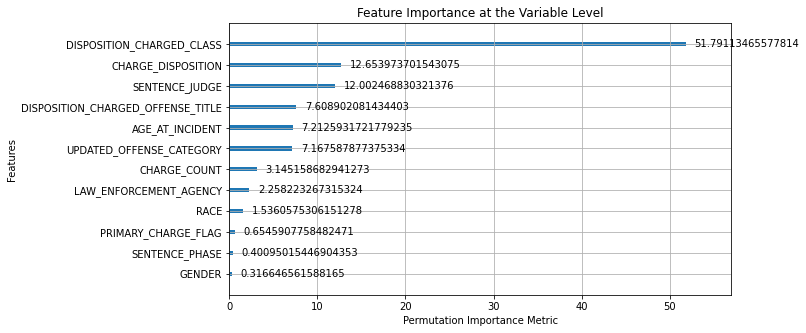

In [60]:
%%time
perm_factor_imps = dict(zip(x_train.columns, res.importances_mean))
xgb.plot_importance(perm_factor_imps,
                xlabel='Permutation Importance Metric'
                   )
plt.gcf().set_size_inches(9,5)
plt.title('Feature Importance at the Variable Level')

# We can see the order is pretty significantly different than the aggregation above, 
# particularly, Charge_Coun (one of the two continuous features) is second above when 
# it is below 50th% in the permutation imp

### Look at correlation between features
Highly correlated features will have deflated feature importances. It is both interesting to know what features are correlated, as well as important to context for reading the feature importances.

In [61]:
from sklearn.feature_selection import f_classif, f_regression, chi2
from scipy.stats import pearsonr, chi2_contingency
import itertools
import statsmodels.api as sm
from dython.nominal import cramers_v, correlation_ratio


**2 kinds of features**: numeric and categorical  
**3 kinds of relations**: numeric-numeric, numeric-categorical, categorical-categorical  
**3 kinds of measures of association**: Pearson r Correlation, Corrlelation Ratio, Cramer's V  
Reference: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [62]:
def dtype_mapper(key):
    key = str(key)
    if key=='object':return 'cat'
    elif key=='bool': return 'cat'
    elif key.startswith('int'): return 'num'
    elif key.startswith('float'): return 'num'
    else:
        raise ValueError(f'unanticipated type: {key}')
        
def split_dtypes(df):
    by_type = df.dtypes.map(dtype_mapper)
    cols_by_type = by_type.groupby(by_type).apply(lambda s: s.index.to_list()).to_dict()
    return cols_by_type


In [63]:
split_dtypes(data)

{'cat': ['PRIMARY_CHARGE_FLAG',
  'DISPOSITION_CHARGED_OFFENSE_TITLE',
  'DISPOSITION_CHARGED_CLASS',
  'CHARGE_DISPOSITION',
  'SENTENCE_JUDGE',
  'SENTENCE_PHASE',
  'RACE',
  'GENDER',
  'LAW_ENFORCEMENT_AGENCY',
  'UPDATED_OFFENSE_CATEGORY'],
 'num': ['CHARGE_COUNT', 'COMMITMENT_TERM', 'AGE_AT_INCIDENT']}

In [64]:
def fill_mat(rows, cols, pairs, metric):
    '''
    Utility to populate matrix cell-wise given combinations 
    of the names of variables from two lists and a pairwise metric.
    '''
    df = pd.DataFrame(index=rows, columns=cols, dtype='float')
    for i, j  in pairs:
        # data is a global var
        res = metric(data[i], data[j])
        df.loc[i, j] = res 
    return df.T # transpose for lower triangle


def get_associations(data):
    '''
    Get association matrix for each the 3 kinds of variable relations.
    '''

    cols_by_type = split_dtypes(data)

    # 'cat2cat': 
    metric = cramers_v
    rows = cols_by_type['cat']
    cols = cols_by_type['cat']
    pairs = itertools.combinations(cols, 2)
    cat2cat = fill_mat(rows, cols, pairs, metric)


    #cat2num
    metric = correlation_ratio # must take (cat var, num var) as first two args
    rows = cols_by_type['cat']
    cols = cols_by_type['num']
    pairs = itertools.product(rows, cols) 
    cat2num = fill_mat(rows, cols, pairs, metric)

    #num2num
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool)) # upper triangle is True
    num2num = corr.mask(mask, np.nan)


    dfs = {'num2num': num2num, 'cat2num': cat2num, 'cat2cat': cat2cat}

    return dfs

In [65]:
%%time
dfs = get_associations(data)

CPU times: user 7.1 s, sys: 285 ms, total: 7.38 s
Wall time: 7.46 s


In [68]:
def plot_associations(dfs):
    '''
    plot the association matrices returned by get_associations()
    '''
    for name, df in dfs.items():
        ax = sns.heatmap(df, annot=True, cmap=None, vmin=-1, vmax=1, center=0,
                    square=False, linewidths=.5, fmt='.2f')
        ax.set(title=name)
        if name == 'cat2num':
            ax.set(xlabel='Categorical Variables', ylabel='Numeric Variables')
        plt.show()

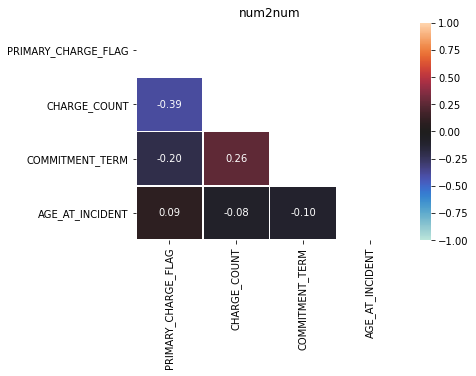

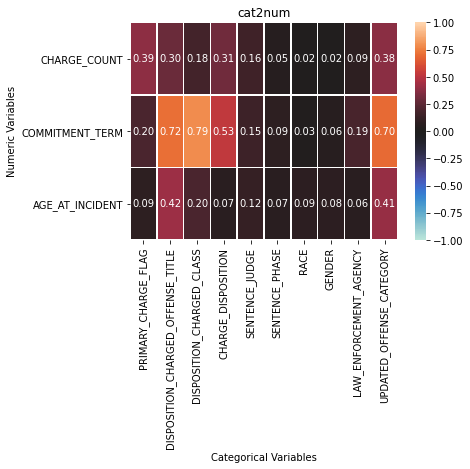

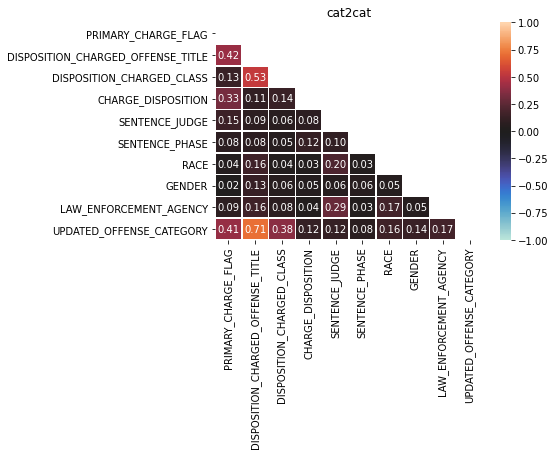

In [69]:
plot_associations(dfs)

**Model Goals:**

* Build a model to predict Sentence Length based on a range of factors including race and criminal charge.
* For each convicted charge, predict the sentence length, then switch the race variable from non-White to White or White to Black, and make the same prediction.
* Calculate the discrepancy between the predicted sentence length with the actual race and the predicted sentence length with the counterfactual race.
* Report the size of the estimated discrepancy in sentencing due to race, and relative severity of the discrepancy compared to past examples.

We need a model that identifies different degrees of racial bias given different case/defendent profiles.


**Limitations and Future Work**:
* Some factors that might be results of racial bias or might capture information about decisions made with racial bias are included in the model that identifies if race was influential which likely decreases the influence of the varaible race, by decreasing its ability to capture all information about racial bias on the sentence because some information about racial bias is being encoded in these other variables (like charge_count). A possible solution could be a sentitivity test to refit the model and asses the influence of race (and the decrease in model accuracy) as you exclude other variables, allowing you to pinpoint which variables are encoding the most information that could be attributed to race.
* we expect past history of convictions to play a significant role in predicting sentence length and be unqually distributed by race. We did not include this factor because limitations in data access, and this is serious limitation in the accuracy of our models. Incorporating this information will be a critical future work step.
* consider class imbalance of black versus white convicted persons
* use age at sentencing not age at incident, to better predict sentence length.